# Preprocesamiento para Experimentos de Actividad Espontánea
 
Este Cuaderno es muy similar al Preprocesamiento para Evocados, pero sin promediar sobre múltiples estímulos. 
Dado que estos experimentos son muy grandes y causan problemas con el RAM, lo que vamos a hacer es primero cortarlos en cachos 
manejables (aproximadamente unos 400MB a lo más), y hacer el preprocesamiento sobre cada subarchivo.
En lugar de eso se recomienda una inspección visual para obtener un intervalo interesante del Archivo Experimental.

In [6]:
push!(LOAD_PATH, ".")
using PreprocTools
using HDF5, PyPlot, Statistics
using Otsu

┌ Info: Recompiling stale cache file /home/karel/.julia/compiled/v1.0/Otsu.ji for Otsu [top-level]
└ @ Base loading.jl:1190


La mayoría de los experimentos de actividad espontánea producen archivos de varios GB. Es imposible hacer el prerprocesamiento con 
memoría limitada. Es muy probable que haya que dividir el archivo en cachos.

In [7]:
abrestring="/home/karel/BRWFiles/Eduardo/Control/Cacho_4_193005_CTRL_Rtn_EMAD_01.h5"
stringgeneral=replace(abrestring, ".brw"=>"")  

"/home/karel/BRWFiles/Eduardo/Control/Cacho_4_193005_CTRL_Rtn_EMAD_01.h5"

In [8]:
abrestring

"/home/karel/BRWFiles/Eduardo/Control/Cacho_4_193005_CTRL_Rtn_EMAD_01.h5"

In [9]:
data=abrecacho(abrestring)

Dict{String,Any} with 3 entries:
  "intervalo" => [15700.0, 16700.0]
  "lfp"       => Float32[-4125.0 0.0 … 0.0 0.0; -12.085 24.1699 … 32.2266 10.07…
  "freq"      => 17.8555

In [10]:
lfp=data["lfp"]
intervalo=data["intervalo"]
freq=data["freq"];
data=0

0

Para archivos monstruosamente grandes, o dividimos automaticamente en cachos todo, o escogemos intervalos interesantes y de ahi trabajamos los cachos.

In [11]:
(rengs, cols, nmax)=size(lfp)

(64, 64, 17857)

In [12]:
tiempototalms=round(nmax/freq; digits=1) 
println("Tienes ", nmax, " cuadros de muestreo a ", round(freq; digits=4), " cuadros por milisegundo")
println( "Esto corresponde a  ", tiempototalms, "ms." )

Tienes 17857 cuadros de muestreo a 17.8555 cuadros por milisegundo
Esto corresponde a  1000.1ms.


In [13]:
fmemlibre=Sys.free_memory()/Sys.total_memory()

0.9249852312551622

In [14]:
exc=lfp[41,34,:];

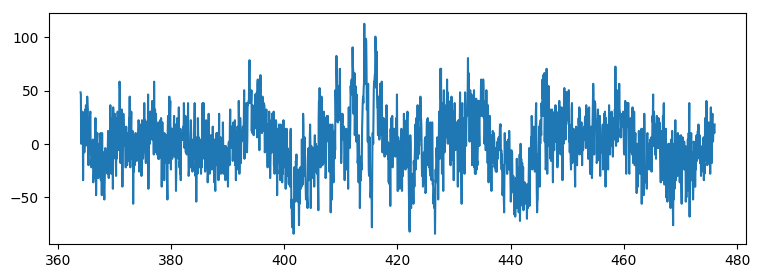

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa8231f04a8>

In [141]:
figure(figsize=(9,3))
inter=6500:8500
it=inter./freq
plot(it, exc[inter])

In [16]:
# De donde a donde quieres recortar
renglonmin=16
renglonmax=50
colmin=32
colmax=64

64

In [17]:
sublfp=lfp[renglonmin:renglonmax, colmin:colmax,:];

In [18]:
round(Sys.free_memory()/Sys.total_memory(),digits=4)

0.9231

In [19]:
#los parametros son datos promediados, frecuencia, tiempo post estimulo en ms, umbral en microvolts, umbral de saturación en microvolts
inib=1 # inicio busqueda en ms
finb=900 # fin busqueda en ms

#conpicos=BuscaCanalRespActPot(lfp, inib, finb, freq,-90,-600,20,35)
saturados=BuscaSaturados(lfp, inib, finb, freq, 801 )
satstd=BuscaSaturadosStd(lfp, inib, finb, freq, 10, 30)
satrd=BuscaRuidosos(lfp, inib, finb, freq, 200, 20)

numerosaturados=length(saturados)
numsatstd=length(satstd)
numsatrd=length(satrd)
#numbom=length(conpicos)

println("Encontramos ", numerosaturados, " canales malos por promedio alto.")
println("Encontramos ", numsatstd, " canales malos por mucha desviacion alto.")
println("Encontramos ", numsatrd, " canales malos por ruidi.")
#println("Encontramos ", numbom, " canales probablemente con actividad.")


Encontramos 19 canales malos por promedio alto.
Encontramos 78 canales malos por mucha desviacion alto.
Encontramos 65 canales malos por ruidi.


In [20]:
malos=union(saturados, satstd, satrd)

Set(Array{Int8,1}[[18, 27], [32, 15], [11, 63], [41, 9], [6, 27], [60, 58], [64, 45], [38, 33], [24, 40], [23, 7]  …  [24, 62], [42, 23], [27, 18], [5, 27], [33, 38], [45, 10], [12, 27], [52, 55], [27, 40], [60, 54], [55, 52]])

In [88]:
function buscasigmaactiva(datos::Array, malos=Set(), venms=50)
    (alto, ancho, largo)=size(datos)
    pur=zeros(alto,ancho)
    for j=1:alto, k=1:ancho
        aux=desviacionventanas(datos[j,k,:], venms, freq)
        pur[j,k]=maximum(aux)
    end
    med=median(pur)
    for q in malos
        reng,col=q[1], q[2]
        pur[reng,col]=med
    end
    return pur
end

buscasigmaactiva (generic function with 3 methods)

In [128]:
#ar=(m1, m2, m3, m4, m5)
ur=(75, 49.995, 50, 50.05, 100)

(75, 49.995, 50, 50.05, 100)

In [129]:
freq*100

1785.5502052190982

In [130]:
?div

search: div divrem DivideError splitdrive mediamov code_native @code_native



```
div(x, y)
÷(x, y)
```

The quotient from Euclidean division. Computes `x/y`, truncated to an integer.

# Examples

```jldoctest
julia> 9 ÷ 4
2

julia> -5 ÷ 3
-1
```


In [131]:
nmax/freq/20

50.004194639290006

In [132]:
for j=1:5
    puf=ur[j]
    aux=buscasigmaactiva(lfp, malos, puf)
    mmms[j]=otsuumbralizar(aux)
end

In [133]:
mmms[1]==mmms[2]

false

In [121]:
fff=mmms[1]+mmms[2]+mmms[4]

64×64 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0  0  0  1  0  …  0  0  0  0  0  1  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  1  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  3  0
 0  0  0  1  0  0  0  0  0  0  0  0  0     0  0  1  0  0  0  0  0  0  0  1  0
 0  0  1  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  0  1  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  1  0  0  0    

In [85]:
mmm=buscasigmaactiva(lfp, malos, 49.5)

64×64 Array{Float64,2}:
 21.6784  21.6642  20.2991  21.654   …  20.9142  22.1216  19.4822  21.0546
 22.931   20.5829  22.1042  20.7076     25.6601  21.9814  21.7134  20.7447
 19.3149  20.7388  26.4588  22.1205     22.4528  22.1779  19.9866  21.9174
 19.611   21.2211  20.0901  22.6992     23.5673  21.1375  43.7516  20.3101
 19.8243  19.5991  23.1271  25.3181     22.498   23.3682  24.5382  23.4097
 21.6518  19.6138  31.0423  20.1424  …  20.0526  21.1802  22.2215  22.4973
 21.9721  21.5614  20.6793  20.5613     22.7855  21.7263  21.1241  21.6744
 20.7064  21.4575  22.1073  20.2507     23.5858  20.5307  22.2156  21.2943
 20.8931  21.741   23.953   19.2577     21.3185  21.5897  21.7794  21.9899
 21.6667  19.3556  21.2951  21.4418     20.2649  22.0105  21.9936  21.0748
 22.3083  22.7565  18.9442  21.0769  …  22.1575  19.9907  21.6784  21.3581
 20.1979  20.772   20.1003  21.5343     21.6784  20.6978  21.0732  20.0112
 21.5441  21.1185  22.4613  21.944      21.0513  20.8845  21.8191  22.0397
 

In [24]:
mm2=buscasigmaactiva(lfp);

### inspección visual. 
Podemos tomar una imagen de la desviación estándar por canal y sobreponerle unas marcas para los canales "respuesta".
De ahí podemos tomar un ejemplo para dibujar el trazo en ese canal.

In [25]:
(alto, ancho, nmax)=size(lfp)
DesviacionPorCanal=zeros(alto,ancho)
ventastd=zeros(alto,ancho)
proms=zeros(alto, ancho)

for j=1:alto
    for k=1:ancho
        ChorizoExemplo=vec(lfp[j,k,:])
        DesviacionPorCanal[j,k]=std(ChorizoExemplo)
        aux=desviacionventanas(ChorizoExemplo, 40, freq)
        ventastd[j,k]=maximum(aux)
        proms[j,k]=sum(ChorizoExemplo)
    end
end

In [71]:
mean(mmm), mean(ventastd)

(23.39155848044902, 47.514840585048205)

In [27]:
using ArraySetTools

In [ ]:
xx1=elemtorow()

In [ ]:
figure(figsize=(9,9))
xlim(0,ancho+1)
ylim(0, alto+1)
title("σ")
limsup=45
liminf=27
imagen=imshow(mmm, origin="lower", interpolation="nearest",cmap="inferno", 
                      vmin=liminf,vmax=limsup, extent=[0.5,ancho+0.5,0.5,alto+0.5])
cb=colorbar()

(x,y)=desetaarray(PruebaRespuesta)

plot([colmin-0.5, colmin-0.5], [renglonmin,renglonmax], lw=2, c="black")
plot([colmin-0.5, colmax+0.5], [renglonmax,renglonmax], lw=2, c="black")
plot([colmax+0.5, colmax+0.5], [renglonmax,renglonmin], lw=2, c="black")
plot([colmax+0.5, colmin-0.5], [renglonmin,renglonmin], lw=2, c="black")


(x2,y2)=desetaarray(saturados)
(x3,y3)=desetaarray(satstd)
(x4,y4)=desetaarray(satrd)


xticks(0:4:64)
yticks(0:4:64)

scatter(x,y, marker="x",c="blue", s=30)
scatter(x2,y2, marker="o",c="lightgreen", s=25)
#scatter(x3,y3, marker="D",c="green", s=25)
#scatter(x4,y4, marker="x",c="green", s=25)
grid(which="both", color="white")

In [86]:
mmmotsu=otsuumbralizar(mmm)
mm2otsu=otsuumbralizar(mm2)

64×64 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0    

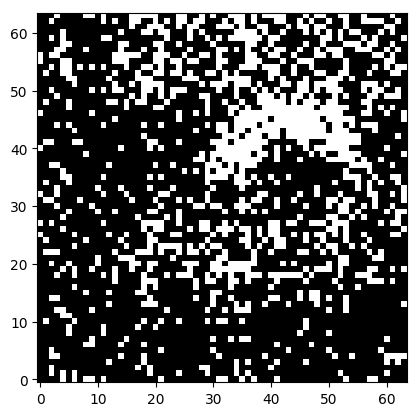

PyObject <matplotlib.image.AxesImage object at 0x7fa823017828>

In [145]:
imshow(mmms[5], cmap="gray", origin="lower")

In [138]:
mmms[3]==mmms[2]

true

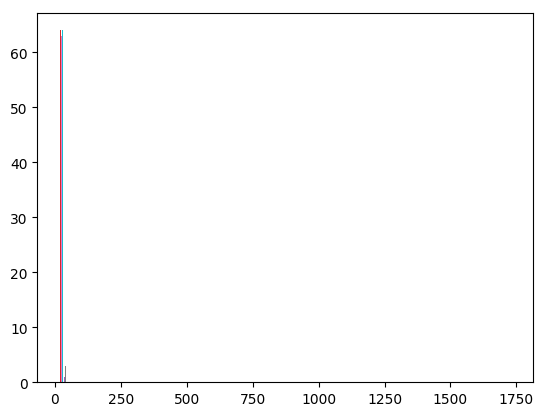

In [73]:
hist(mmm, bins=128);

In [110]:
nmax

17857

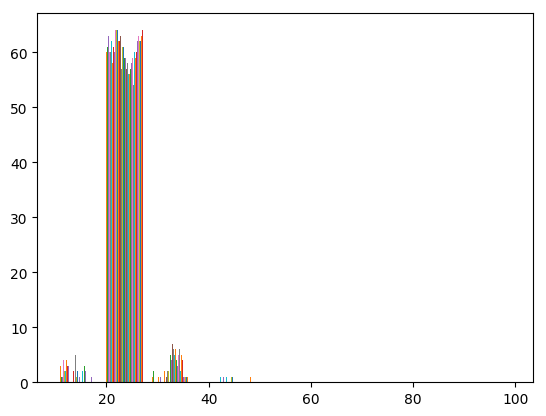

In [75]:
hist(mmm, range=(10,100));

In [53]:
?hist

search: hist hist2D clear_history pushfirst! searchsortedfirst thisind



Plot a histogram.

Compute and draw the histogram of *x*. The return value is a
tuple (*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*,
[*patches0*, *patches1*,...]) if the input contains multiple
data.

Multiple data can be provided via *x* as a list of datasets
of potentially different length ([*x0*, *x1*, ...]), or as
a 2-D ndarray in which each column is a dataset.  Note that
the ndarray form is transposed relative to the list form.

Masked arrays are not supported at present.

Parameters
----------
x : (n,) array or sequence of (n,) arrays
    Input values, this takes either a single array or a sequence of
    arrays which are not required to be of the same length.

bins : int or sequence or str, optional
    If an integer is given, ``bins + 1`` bin edges are calculated and
    returned, consistent with `numpy.histogram`.

    If `bins` is a sequence, gives bin edges, including left edge of
    first bin and right edge of last bin.  In this case, `bins` is
    returned unmod

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = show(::IOContext{Base.GenericIOBuffer{Array{UInt8,1}}}, ::MIME{Symbol("text/plain")}, ::PyPlot.LazyHelp) at PyPlot.jl:28
└ @ PyPlot /home/karel/.julia/packages/PyPlot/KRYZs/src/PyPlot.jl:28


In [51]:
(cuac, cuc,coc)=otsumethod(mmm)

(5.191877163206256e10, 3, 40.0)

In [37]:
mean(mmm), std(mmm)

(22.171650435309857, 2.530291872048829)

In [ ]:
 tantos=length(rango)
    #valores
    omega1=0
    omega2=0
    mu1=0
    mu2=0
    sigmab=0
    sigmabtemp=0
    tbest=0
    varlim=0
    for t=1:tantos-1
        omega1=sum(cuentas[1:t])
        omega2=sum(cuentas[t+1:tantos-1])
        mu1=sum(cuentas[1:t].*rango[1:t])/omega1
        mu2=sum(cuentas[t+1:tantos-1].*rango[t+1:tantos-1])/omega2        
        sigmabtemp=omega1*omega2*((mu1-mu2)^2)
        if sigmabtemp>sigmab
            sigmab=sigmabtemp
            tbest=t
            varlim=rango[t]
        end
    end

In [ ]:
tbest

In [ ]:
typeof(h.edges[1])

In [ ]:
median(ventastd), std(ventastd)

In [ ]:
egtrazo=lfp[28,42,:];

In [ ]:
std(egtrazo)

In [ ]:
?hist

Escogamos uno de los que parecen estar en la "sombra luminosa" del Cuerno de Amon y que estén marcados con x blanca.

In [ ]:
figure(figsize=(12,4))
xlabel("cuadros")
ylabel("mV")
ylim(-100,100)
#subintervalo a graficar, por omision, todo primero, es decir desde=1, hasta=cuadrosmax
desde=6
hasta=1200
#intervalo=1:cacho
intervalo=desde:hasta
it=intervalo./freq
grid()
plot(it,egtrazo[intervalo], lw=2)

Tomaremos el intervalo interesante y guardaremos esos datos en un archivo con toda la información de saturados y respuestas, 
de la misma forma que como se hace con los evocados. A diferencia de éstos, no tenemos parámetros de latencia, en lugar de eso
tendremos una indicacion de "de donde a donde se cortaron los datos", en cuadros.

In [ ]:
dirname(stringgeneral), basename(stringgeneral)

In [ ]:
dirgen=dirname(stringgeneral)
basegen=basename(stringgeneral)
#una palabra para indicar el intervalo 
indicadorespecifico="_subdatos.h5"
outname=string(dirgen,palabritaespecial, basegen, indicadorespecifico)
#aqui hay que arreglar el rollo del directorio

listaaguardar=Dict(
    "LFPRecortado" => Subdatos,
     "cols" => [colmin, colmax],
      "rengs" => [renglonmin, renglonmax],
     "freq" =>freq,
     "Canalesrespuesta" => PruebaRespuesta,
     "CanalesSaturados" => Saturados)

println(outname )
   h5open(outname, "w")  do file
        for k in keys(listaaguardar)
            datos=listaaguardar[k]
            println("abriendo los datos ", k)
            println
            write(file, "$k", datos)
        end
    end

println("hemos guardado este cacho en el archivo ", outname)


In [ ]:
typeof(Subdatos)

In [ ]:
Subdatos=convert.(Float32, Subdatos)